In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as m


In [2]:
df = pd.read_csv("customerPurchase.csv")
df.head()

CustomerID   Age  Gender  AnnualIncome  PurchaseAmount  PurchaseFrequency  \
0         1.0  56.0    Male       70225.0      125.635565               48.0   
1         2.0  69.0    Male       57952.0      156.417933                NaN   
2         3.0  46.0   Other       57663.0      244.151650               39.0   
3         4.0  32.0  Female       81381.0       36.275633               29.0   
4         5.0  60.0    Male       67929.0      307.515054               24.0   

  LastPurchaseDate ProductCategory  LoyaltyProgramMember  CustomerRating  
0       01-01-2023            Toys                   0.0        1.210366  
1       02-01-2023           Books                   0.0        3.201970  
2       03-01-2023            Toys                   0.0        2.229175  
3       04-01-2023           Books                   1.0        3.134410  
4              NaN        Clothing                   1.0        1.537188

In [3]:
categorical_columns = ['Gender','ProductCategory']
numerical_columns = ['Age','Gender','AnnualIncome','PurchaseAmount','PurchaseFrequency',]

In [4]:
#Let us do some statistical analysis on the above dataset..
print("The Shape of Dataset is = ",df.shape)
print(df.info())
print(df.describe(include='all'))

The Shape of Dataset is =  (3000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            2947 non-null   float64
 1   Age                   2962 non-null   float64
 2   Gender                2964 non-null   object 
 3   AnnualIncome          2955 non-null   float64
 4   PurchaseAmount        2956 non-null   float64
 5   PurchaseFrequency     2945 non-null   float64
 6   LastPurchaseDate      2965 non-null   object 
 7   ProductCategory       2949 non-null   object 
 8   LoyaltyProgramMember  2954 non-null   float64
 9   CustomerRating        2957 non-null   float64
dtypes: float64(7), object(3)
memory usage: 234.5+ KB
None
         CustomerID          Age Gender   AnnualIncome  PurchaseAmount  \
count   2947.000000  2962.000000   2964    2955.000000     2956.000000   
unique          NaN          NaN    

In [5]:
#First and Foremost Handle the missing values..
df_missing_values = df.isnull().sum()
df_missing_values


CustomerID              53
Age                     38
Gender                  36
AnnualIncome            45
PurchaseAmount          44
PurchaseFrequency       55
LastPurchaseDate        35
ProductCategory         51
LoyaltyProgramMember    46
CustomerRating          43
dtype: int64

In [6]:
# calculate the percentage of missing values..
proportion = df.isnull().mean()
print(proportion.mean())
for col in df.columns:
    if df[col].isnull().mean() < 0.05:
        df.dropna(subset=[col],inplace=True)
        
print(df.isnull().sum())


0.014866666666666667
CustomerID              0
Age                     0
Gender                  0
AnnualIncome            0
PurchaseAmount          0
PurchaseFrequency       0
LastPurchaseDate        0
ProductCategory         0
LoyaltyProgramMember    0
CustomerRating          0
dtype: int64


In [7]:
df.shape

(2582, 10)

In [8]:
#since the customerid is not neccessary for outlier detection we can drop it..
df.drop(columns=['CustomerID'],axis=1,inplace=True)

In [9]:
df.head()



Age  Gender  AnnualIncome  PurchaseAmount  PurchaseFrequency  \
0  56.0    Male       70225.0      125.635565               48.0   
2  46.0   Other       57663.0      244.151650               39.0   
3  32.0  Female       81381.0       36.275633               29.0   
5  25.0    Male       29343.0      491.948842               22.0   
6  38.0  Female       96173.0      183.599124                6.0   

  LastPurchaseDate ProductCategory  LoyaltyProgramMember  CustomerRating  
0       01-01-2023            Toys                   0.0        1.210366  
2       03-01-2023            Toys                   0.0        2.229175  
3       04-01-2023           Books                   1.0        3.134410  
5       06-01-2023        Clothing                   1.0        4.730520  
6       07-01-2023            Toys                   1.0        4.578085

In [10]:
#Performing Categorical Encoding..
df = pd.get_dummies(df,columns=categorical_columns,drop_first=True,dtype=int)

# Convert 'LastPurchaseDate' to a numerical feature representing days since the last purchase
df['LastPurchaseDate'] = pd.to_datetime(df['LastPurchaseDate'], format="%d-%m-%Y")
latest_date = df['LastPurchaseDate'].max()
df['DaysSinceLastPurchase'] = (latest_date - df['LastPurchaseDate']).dt.days
df.drop(columns=['LastPurchaseDate'], inplace=True)


In [11]:
df.head()

Age  AnnualIncome  PurchaseAmount  PurchaseFrequency  \
0  56.0       70225.0      125.635565               48.0   
2  46.0       57663.0      244.151650               39.0   
3  32.0       81381.0       36.275633               29.0   
5  25.0       29343.0      491.948842               22.0   
6  38.0       96173.0      183.599124                6.0   

   LoyaltyProgramMember  CustomerRating  Gender_Male  Gender_Other  \
0                   0.0        1.210366            1             0   
2                   0.0        2.229175            0             1   
3                   1.0        3.134410            0             0   
5                   1.0        4.730520            1             0   
6                   1.0        4.578085            0             0   

   ProductCategory_Clothing  ProductCategory_Electronics  \
0                         0                            0   
2                         0                            0   
3                         0                            0   
5                         1                            0   
6                         0                            0   

   ProductCategory_Home  ProductCategory_Toys  DaysSinceLastPurchase  
0                     0                     1                   2999  
2                     0                     1                   2997  
3                     0                     0                   2996  
5                     0                     0                   2994  
6                     0                     1                   2993

In [12]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [13]:
df_scaled.head()
df_scaled.to_csv("customerPurchaseScaled.csv",index=False)

In [14]:
#Coming to the model building..
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model
anomalies = model.fit_predict(df_scaled)
df_scaled['Outlier'] = model.fit_predict(df_scaled)

# Outliers are marked as -1, normal points as 1
outliers = df_scaled[df_scaled['Outlier'] == -1]
normal_points = df_scaled[df_scaled['Outlier'] == 1]
print(len(outliers),len(normal_points))


259 2323


In [15]:
import pickle as p
with open('./model.pkl','wb') as f:
    p.dump(model,f)
with open('./scaler.pkl', 'wb') as f:
    p.dump(df_scaled,f)

In [16]:
outliers.head()
# outliers.shape

Age  AnnualIncome  PurchaseAmount  PurchaseFrequency  \
0   0.838599      0.014993       -0.890267           1.608270   
3  -1.246488     -1.386297        1.662891          -0.223128   
5   0.838599     -0.342647        0.866309           1.608270   
13 -1.582792      0.440981       -0.384528           1.396955   
14 -0.304836     -1.236989        1.343022          -1.350142   

    LoyaltyProgramMember  CustomerRating  Gender_Male  Gender_Other  \
0              -1.011687       -1.577062     1.401574     -0.711630   
3               0.988448        1.492901     1.401574     -0.711630   
5               0.988448       -1.097732     1.401574     -0.711630   
13             -1.011687        0.054674    -0.713484      1.405224   
14              0.988448        1.486258     1.401574     -0.711630   

    ProductCategory_Clothing  ProductCategory_Electronics  \
0                  -0.507010                    -0.490055   
3                   1.972347                    -0.490055   
5                  -0.507010                    -0.490055   
13                 -0.507010                    -0.490055   
14                 -0.507010                    -0.490055   

    ProductCategory_Home  ProductCategory_Toys  DaysSinceLastPurchase  Outlier  
0              -0.490055              1.956059               1.729853       -1  
3              -0.490055             -0.511232               1.724056       -1  
5               2.040588             -0.511232               1.721737       -1  
13              2.040588             -0.511232               1.711304       -1  
14             -0.490055              1.956059               1.710144       -1

<Figure size 800x1000 with 0 Axes>

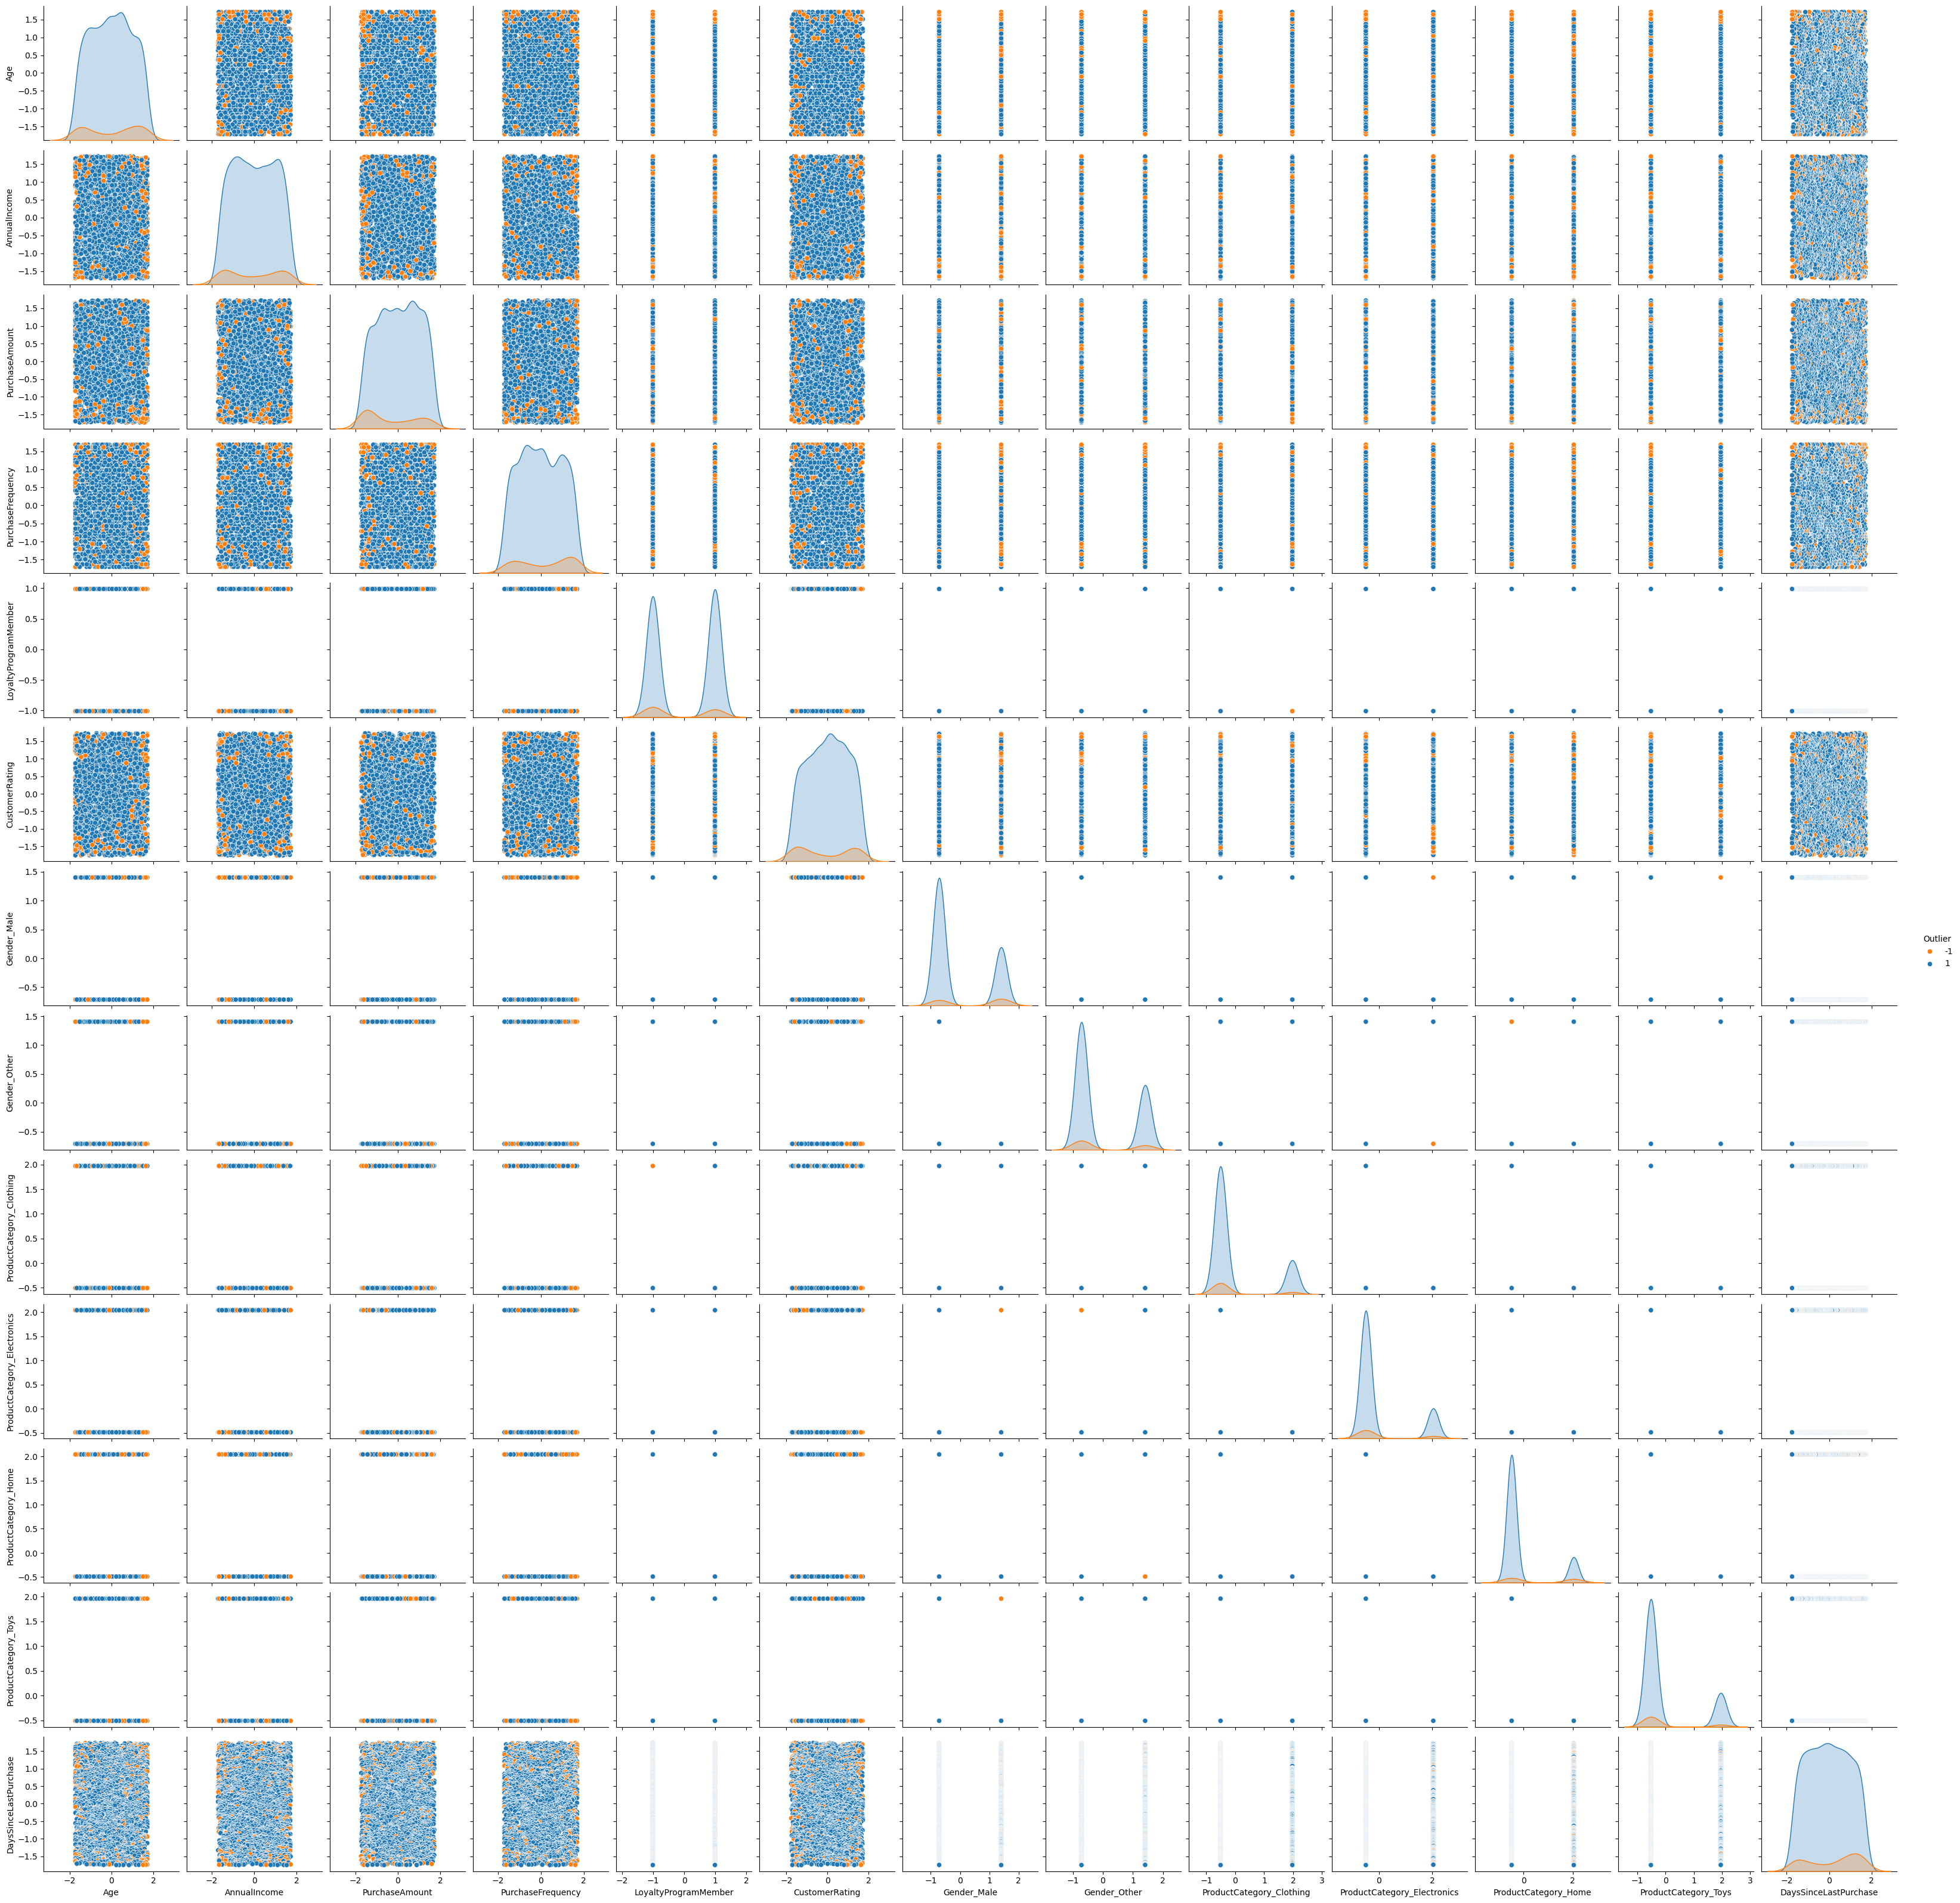

In [17]:
#Using PairPlot I Have Plot the visualization of different combination of feature
colors = ["#ff7f0e","#1f77b4"]
plt.figure(figsize=(8,10))
sns.pairplot(df_scaled,hue="Outlier",palette=colors)

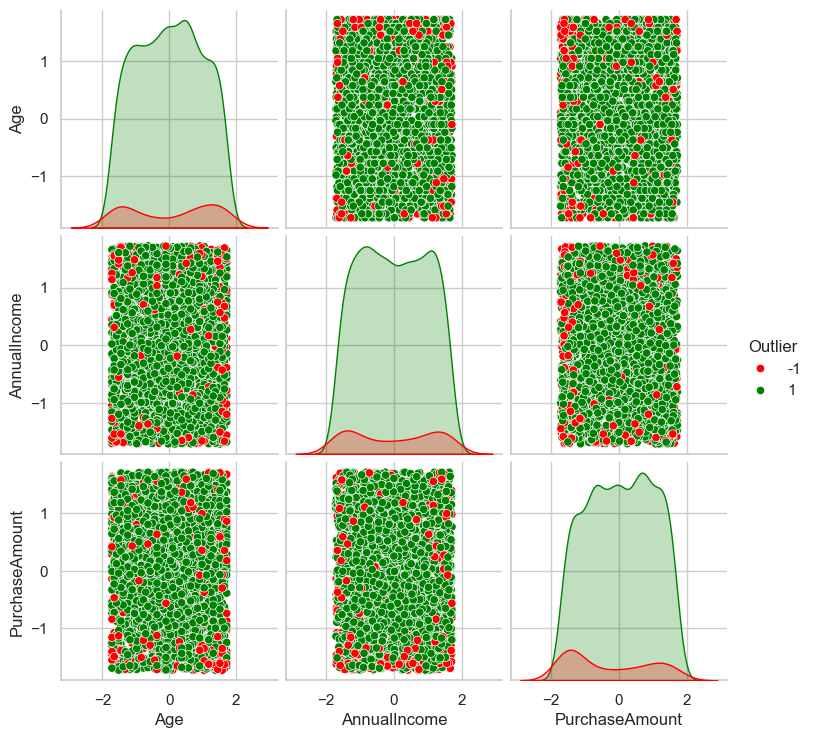

In [23]:
sns.pairplot(df_scaled,hue='Outlier',vars=['Age','AnnualIncome','PurchaseAmount'],palette={1:'green',-1:'red'})

       pca1      pca2  outlier
0  1.560987 -1.028266       -1
1 -1.479207 -0.813094        1
2  0.123334 -0.081736        1
3  1.957407  2.181541       -1
4  0.055738 -1.042495        1


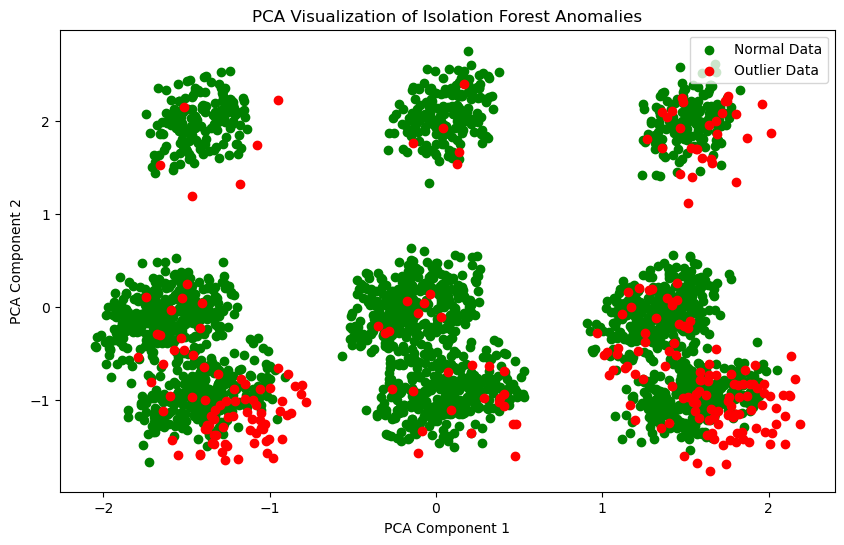

In [19]:
from sklearn.decomposition import PCA

# Reduce to 2D with PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data=pca_transformed,columns = ['pca1','pca2'])
plt.figure(figsize=(10, 6))
pca_df['outlier'] = anomalies
print(pca_df.head())
pca_outlier = pca_df[pca_df['outlier'] == -1]
pca_inlier = pca_df[pca_df['outlier'] == 1]
plt.scatter(x = pca_inlier['pca1'], y = pca_inlier['pca2'], c='green', label='Normal Data')
plt.scatter(x = pca_outlier['pca1'], y = pca_outlier['pca2'], c='red', label='Outlier Data')


plt.title('PCA Visualization of Isolation Forest Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


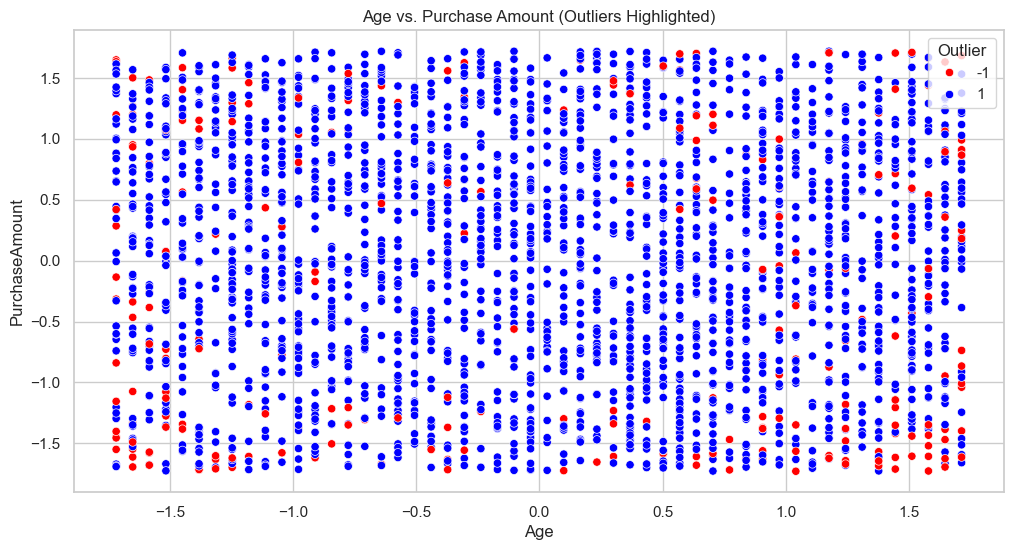

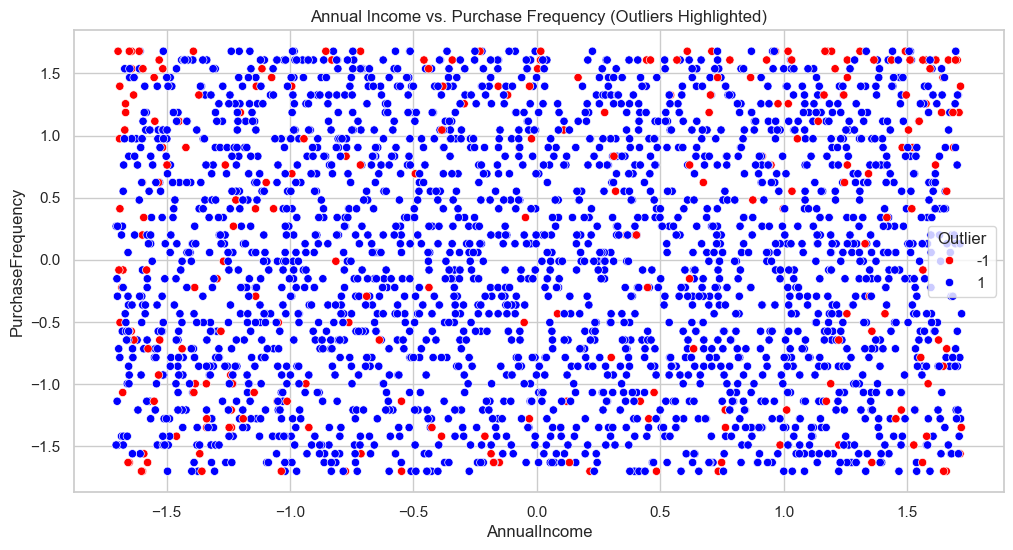

In [20]:
sns.set(style="whitegrid")

# Plotting the distribution of Age vs. PurchaseAmount with outliers highlighted
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Age', y='PurchaseAmount', hue='Outlier', data=df_scaled, palette={1: 'blue', -1: 'red'})
plt.title('Age vs. Purchase Amount (Outliers Highlighted)')
plt.show()

# Plotting the distribution of AnnualIncome vs. PurchaseFrequency with outliers highlighted
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AnnualIncome', y='PurchaseFrequency', hue='Outlier', data=df_scaled, palette={1: 'blue', -1: 'red'})
plt.title('Annual Income vs. Purchase Frequency (Outliers Highlighted)')
plt.show()

In [21]:
#Analyze the characteristics of outliers
outliers.describe(include='all')

Age  AnnualIncome  PurchaseAmount  PurchaseFrequency  \
count  259.000000    259.000000      259.000000         259.000000   
mean     0.046011     -0.026952       -0.321393           0.176114   
std      1.239790      1.206543        1.198155           1.199726   
min     -1.717314     -1.696705       -1.728502          -1.702333   
25%     -1.246488     -1.243519       -1.453282          -0.997950   
50%      0.300512     -0.021648       -0.683993           0.410818   
75%      1.242164      1.183650        0.897560           1.361736   
max      1.712990      1.719596        1.709111           1.678708   

       LoyaltyProgramMember  CustomerRating  Gender_Male  Gender_Other  \
count            259.000000      259.000000   259.000000    259.000000   
mean              -0.146764       -0.104281     0.446123     -0.008737   
std                0.992813        1.269498     1.054629      0.998857   
min               -1.011687       -1.759643    -0.713484     -0.711630   
25%               -1.011687       -1.385268    -0.713484     -0.711630   
50%               -1.011687       -0.255591     1.401574     -0.711630   
75%                0.988448        1.200058     1.401574      1.405224   
max                0.988448        1.720538     1.401574      1.405224   

       ProductCategory_Clothing  ProductCategory_Electronics  \
count                259.000000                   259.000000   
mean                  -0.124098                     0.076653   
std                    0.897700                     1.057020   
min                   -0.507010                    -0.490055   
25%                   -0.507010                    -0.490055   
50%                   -0.507010                    -0.490055   
75%                   -0.507010                    -0.490055   
max                    1.972347                     2.040588   

       ProductCategory_Home  ProductCategory_Toys  DaysSinceLastPurchase  \
count            259.000000            259.000000             259.000000   
mean               0.614048             -0.063500               0.190953   
std                1.257439              0.952747               1.180136   
min               -0.490055             -0.511232              -1.741107   
25%               -0.490055             -0.511232              -1.014223   
50%               -0.490055             -0.511232               0.514901   
75%                2.040588             -0.511232               1.258595   
max                2.040588              1.956059               1.729853   

       Outlier  
count    259.0  
mean      -1.0  
std        0.0  
min       -1.0  
25%       -1.0  
50%       -1.0  
75%       -1.0  
max       -1.0

In [22]:
	# •	Total Outliers Identified: 259 (10% of the dataset, as specified by the contamination parameter).
	# •	Summary of Outliers:
	# •	Age: The outliers have a wide age range.
	# •	Annual Income: The income among outliers varies greatly, indicating that income alone may not be a direct indicator of abnormal behavior.
	# •	Purchase Amount: Outliers show significantly high variability in purchase amounts, which could indicate unusual spending patterns.
	# •	Purchase Frequency: The outliers purchase frequencies range from very low to high, with a mean of 21.3.

